In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset,ConcatDataset
import torch.nn as nn
import torch.optim as optim
import librosa
from tqdm import tqdm
from scipy.stats import skew
import seaborn as sns
from collections import Counter
import torchaudio
import pretty_midi
import os
from librosa.feature import rhythm
import random
import torch.nn.functional as F
from torchmetrics import F1Score

# Music analysis and transcription deep learning model: Classical and modern genres

## Project Overview

This project focuses on analyzing classical and modern music datasets to uncover key audio characteristics and develop deep learning models for automatic music transcription. We utilize the Mini MusicNet dataset for classical music and the BabySLakh dataset for modern music, examining features such as waveforms, sparsity, mel spectrograms, and statistical moments. The process involves exploratory data analysis, preprocessing to prepare the data, and selecting an appropriate deep learning model based on task requirements, time constraints, and computational complexity. We evaluate model performance, discuss results, and propose potential enhancements while addressing challenges for improved transcription accuracy.

# Classical music EDA

To begin with, I am going to use a dataset that contains classical music. It is probably the easiest to transcribe into notes. We are going to begin by getting some data. The source I am using is from Mini MusicNet since the big MusicNet contains a huge amount of data that would require a lot of computational power and time.

Let us explain how our data looks like. We have a lot of data points, 82,500 samples to be exact. Each of them has 4096 features. We expect those 4096 features to be the **raw amplitudes.** To make it simpler:

- **Number of samples:** 82,500  
- **Input features per sample:** 4,096 (representing audio features)  
- **Output labels per sample:** 128 (binary indicators for each note)  
- **Duration per sample:** 9 milliseconds  
- **Sampling rate:** 16,000 Hz  


Before doing anything, it is important to notice something crucial. Although the **duration of a raw audio sample is only 9 ms**, each data point has **4,096 features**.

At first glance, one might expect the duration corresponding to 4,096 raw samples at 16 kHz to be:
$$
\frac{4,096}{16,000} = 0.256 \, \text{seconds} = 256 \, \text{ms}
$$

which is **much longer than 9 ms**.

This indicates that the 4,096 features are **not raw audio samples**, but rather **precomputed features** (e.g., spectral features, log-mel coefficients, or other transformations) extracted from the 9 ms snippet. Each feature vector summarizes information about the snippet in a way that allows a model to learn musical content despite the very short duration of the raw audio.

If we open the github repository of the mini MusicNet we would see that plotting the audio signal using those features is explained as **"raw audio signals" which could be misleading.**

In [2]:
# Loading data 
Xtrain = np.load('audio-train.npy')
Ytrain = np.load('labels-train.npy')
Xvalid = np.load('audio-valid.npy')
Yvalid = np.load('labels-valid.npy')
Xtest = np.load('audio-test.npy')
Ytest = np.load('labels-test.npy')

Now that we have loaded the data we can give an example of how the raw data looks like. **The data we are using are 9ms recording.**

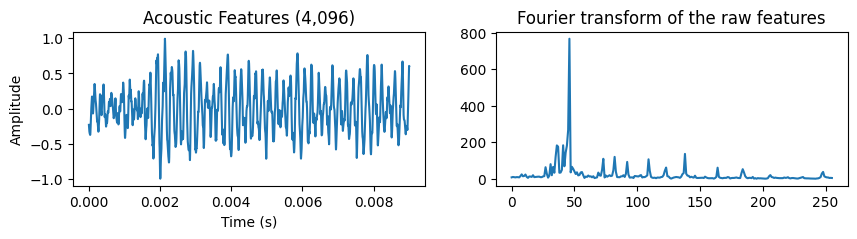

In [3]:
# Plot for sample 2
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
ax[0].set_title('Acoustic Features (4,096)')
ax[0].plot(np.linspace(0, 9e-3, 4096), Xtrain[2])  # Scale to 9ms
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

ax[1].set_title('Fourier transform of the raw features')
ax[1].plot(np.abs(np.fft.rfft(Xtrain[2])[0:256])) # clip to 256 features for easier visualization
plt.show()

What we just did was to take one of the files we have, show it's raw version and then the fourier transform. 
- **Left plot:**  
  This shows the audio waveform values over time for one sample from `Xtrain[2]`. The x-axis represents the time steps or audio samples (ranging approximately from 0 to 9 ms), and the y-axis shows the amplitude of the audio signal at each time step (ranging from about -1 to 1). The waveform represents how the air pressure (sound wave) changes over time in the audio clip.

- **Right plot :**  
  This shows the magnitude of the frequency-like components of the precomputed feature vector.
The x-axis represents the bin index of the FFT applied to the 4,096-dimensional feature vector, and the y-axis represents the amplitude of each component.
**These are not true audio frequencies**, but a way to visualize patterns in the feature vector.


Generally we could calculate the frequency using:
$$
f = \frac{\text{bin\_index} \times f_s}{N}
$$

where:  
- $ f $ is the frequency corresponding to the FFT bin,  
- $ \text{bin\_index} $ is the index of the FFT bin (0, 1, 2, $\ldots$),  
- $ f_s $ is the sampling rate (in Hz),  
- $ N $ is the FFT size (number of samples).

However, there is a pitfall we should not fall for.

**False Example:**  
If the sampling rate $ f_s = 16,000 $ Hz, FFT size $ N = 4,096 $, and the bin index is 50, then the frequency is:

$$
f = \frac{50 \times 16,000}{4,096} \approx 195.31 \text{ Hz}
$$

We cannot find the frequency like that considering the fact that we do not have the raw signal, but a signal with precomputed features. This once again is something that has not been well documented in the github repo

Let us take a look at a picture of frequencies to get an intuition before moving forward.
<img src="https://musicmaster.in/music-tools/tuner/string-freq.png" alt="Guitar Tuning Frequencies" width="400"/>

Now that we are familiar with what the waveforms look like we are going to go through some simple analysis of the data so we have an idea of what we are working with.

In [4]:
print("Xtrain shape:", Xtrain.shape)
print("Ytrain shape:", Ytrain.shape)
print("Xtest shape:", Xtest.shape)
print("Ytest shape:", Ytest.shape)

Xtrain shape: (62500, 4096)
Ytrain shape: (62500, 128)
Xtest shape: (10000, 4096)
Ytest shape: (10000, 128)


In [5]:
print("Number of active notes per sample (mean):", np.mean(np.sum(Ytrain, axis=1)))
print("Label sparsity:", np.mean(Ytrain))  # Proportion of 1s in labels

Number of active notes per sample (mean): 2.941808
Label sparsity: 0.022982875


What we just did was calculate the average number of active notes per sample. We achieved this by summing the columns of `Ytrain`, which is multi-one-hot encoded: each entry is `1` if a note is active in a given sample and `0` otherwise.

Before we keep on with the preprocessing of the data I am going to run some analysis on the frequencies we got.

In [6]:
print("Xtrain dtype:", Xtrain.dtype)
print("Ytrain dtype:", Ytrain.dtype)

Xtrain dtype: float32
Ytrain dtype: float64


We see that the Xtrain and the Ytrain are of different types. We are going to change that so that we can pass them more safely to our model later on.

In [7]:
Ytrain = Ytrain.astype(np.float32)

In [8]:
print("Sample Xtrain[0]:", Xtrain[0])
print("Sample Ytrain[0]:", Ytrain[0])

Sample Xtrain[0]: [-0.01537969 -0.0221083  -0.03524511 ...  0.16404998  0.17494392
  0.19032362]
Sample Ytrain[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


We can also see the relationship between played and unplayed notes.

Unique labels and counts: {0.0: 7816137, 1.0: 183863}


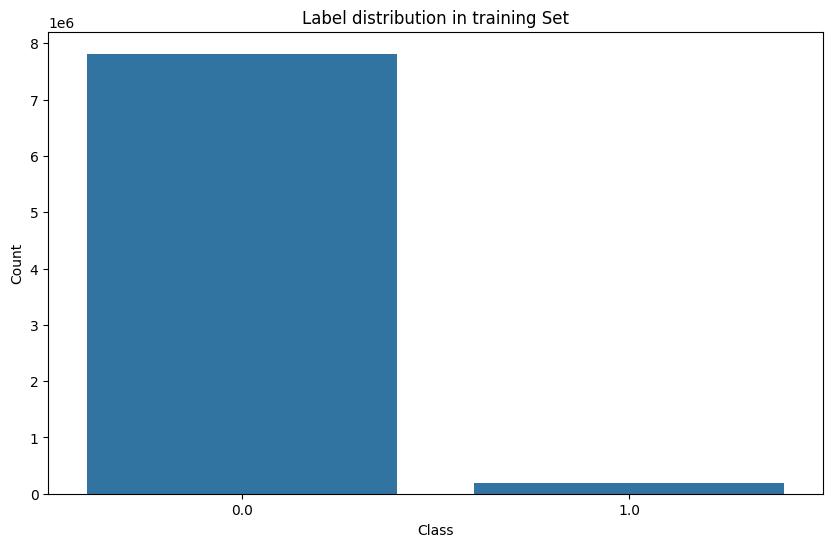

In [9]:


unique, counts = np.unique(Ytrain, return_counts=True)
print("Unique labels and counts:", dict(zip(unique, counts)))

# Visualize label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=Ytrain.ravel())
plt.title("Label distribution in training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

This gives us some important information telling us that the dataset is highly unbalanced. **In this case it is not reasonable and logical to under or oversample since it will affect the results.** We will deal with this problem later on.

#### Checking normality of data
I am going to see the mean, std, min and max of the `Xtrain` dataset in order to know if any normalization might be necessary before working with model.

In [10]:
print("Xtrain stats - Mean:", np.mean(Xtrain), "Std:", np.std(Xtrain), 
      "Min:", np.min(Xtrain), "Max:", np.max(Xtrain))

Xtrain stats - Mean: -8.922857e-06 Std: 0.34472543 Min: -1.0 Max: 1.0


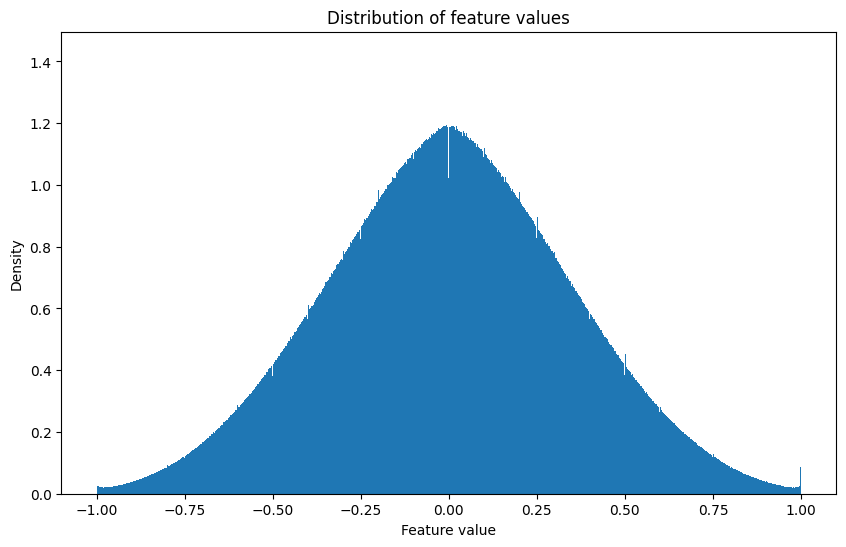

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(Xtrain.flatten(), bins=1000, density=True)
plt.title("Distribution of feature values")
plt.xlabel("Feature value")
plt.ylabel("Density")
plt.show()

What we just took a look at is the distribution of the features values in the Xtrain. We can easily see that they are equally distributed with a mean close to 0 and a standartd deviation of 0.34 which is something very standard. This is absolutely expected normalized audio data.

## Mean amplitude, variance, skewness
To gain some more information about the characteristics in our dataset, I will analyze three fundamental statistical properties: **mean amplitude, variance, and skewness** for both the training and validation sets. These metrics provide insights into the overall structure and distribution of the audio signals. The mean amplitude indicates the average energy level, variance reflects the dynamic range or intensity fluctuations, and skewness reveals the asymmetry in the signal distribution. 

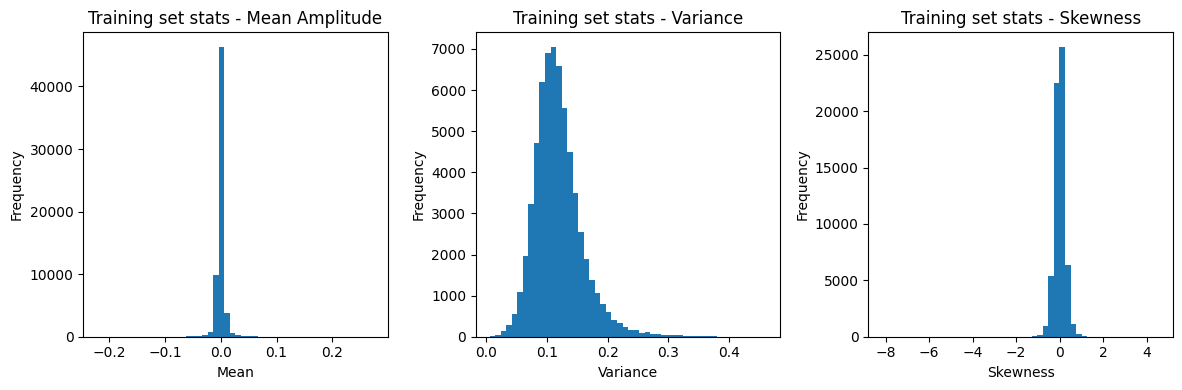

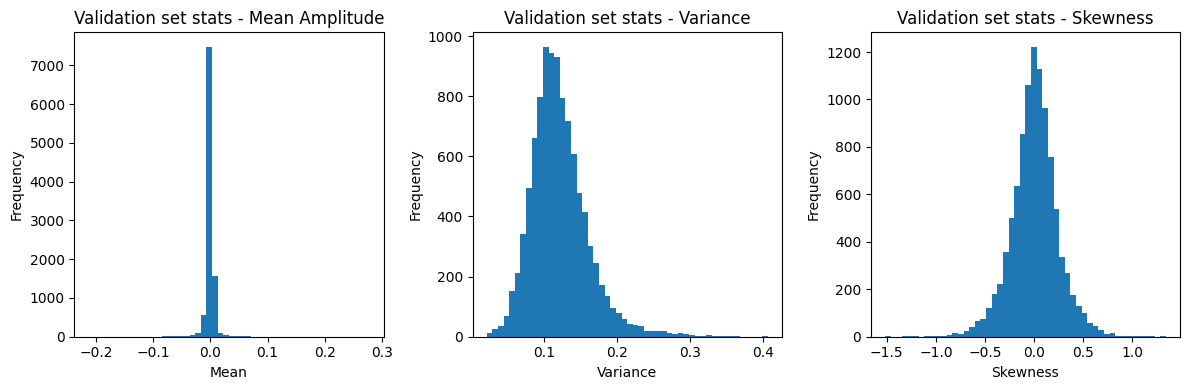

In [12]:
def plot_waveform_stats_safe(X, title, batch_size=5000):
    means_list, var_list, skew_list = [], [], []
    
    for i in range(0, X.shape[0], batch_size):
        batch = X[i:i+batch_size]
        means_list.append(np.mean(batch, axis=1))
        var_list.append(np.var(batch, axis=1))
        skew_list.append(skew(batch, axis=1))
    
    # Combine all batches
    means = np.concatenate(means_list)
    variances = np.concatenate(var_list)
    skewness = np.concatenate(skew_list)
    
    # Plot
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(means, bins=50)
    plt.title(f"{title} - Mean Amplitude")
    plt.xlabel("Mean")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 2)
    plt.hist(variances, bins=50)
    plt.title(f"{title} - Variance")
    plt.xlabel("Variance")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 3)
    plt.hist(skewness, bins=50)
    plt.title(f"{title} - Skewness")
    plt.xlabel("Skewness")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()
plot_waveform_stats_safe(Xtrain, "Training set stats")
plot_waveform_stats_safe(Xvalid, "Validation set stats")


### Moments
1. In the first plot the narrow distribution around 0 indicates that the audio samples are likely preprocessed, which is standard for machine learning tasks. However, the extreme concentration suggests limited variability in amplitude. Pretty much the same is seen with the validation set, with a lower freqency of course, since it contains less samples.
2. The variance distribution has a broad peak between 0.1 and 0.2, with a high frequency in this range, dying off as variance increases beyond 0.3. This shows that most samples have moderate variability in amplitude.
3. The last plot showing skewness measures the asymmetry of the amplitude distribution. A value near 0 indicates a symmetric distribution, which is expected if the audio is well-balanced. The dominance of 0 skewness aligns with normalized data.

## Absolute mean
In the last task we saw that the mean of the amplitude is around zero suggesting well-distributed data. Now however we will look at one more thing, which is the absolute mean.

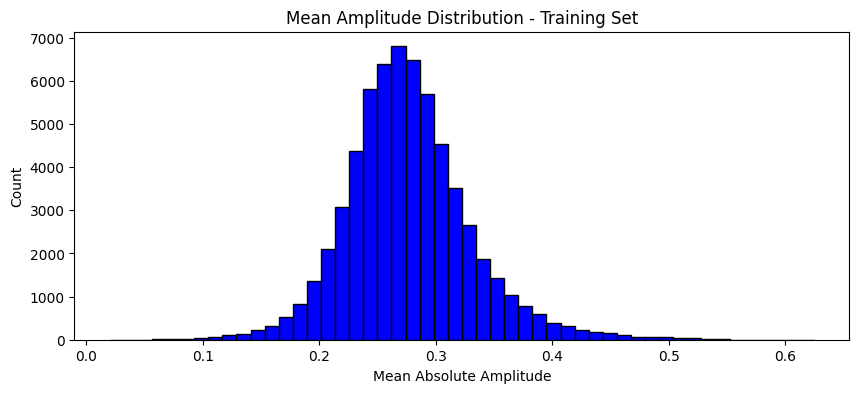

Mean of mean amplitudes: 0.27614978
Mean of std amplitudes: 0.3401256
Mean of peak-to-peak: 1.8715175


In [13]:

mean_amplitudes = np.mean(np.abs(Xtrain), axis=1)
std_amplitudes = np.std(Xtrain, axis=1)
peak_to_peak = np.ptp(Xtrain, axis=1)


plt.figure(figsize=(10, 4))
plt.hist(mean_amplitudes, bins=50, color='blue', edgecolor='black')
plt.title('Mean Amplitude Distribution - Training Set')
plt.xlabel('Mean Absolute Amplitude')
plt.ylabel('Count')
plt.show()

# Print basic statistics
print("Mean of mean amplitudes:", np.mean(mean_amplitudes))
print("Mean of std amplitudes:", np.mean(std_amplitudes))
print("Mean of peak-to-peak:", np.mean(peak_to_peak))


Again, from this analysis, we can say that our data is acting as expected, showing consistent amplitude ranges, variability, and dynamic range across samples - indicating good signal quality and no major anomalies that would require immediate preprocessing adjustments.

## Analyzing energy

### What is RMS?

Something that I am only going to mention is the RMS. **The RMS measure of the average power or intensity of an audio signal over time.** It is calculated with the formula: $$ \text{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^N x_i^2}$$
where:
- $x(t)$ is a waveform
- $N$ is the number of samples

Before we go further, I am going to explain frame length and hop length which are necessary parameters that we are going to deal with. When we want to calculate the RMS it is not only necessary to have the waveforms and the number of samples. We need to decide how we are going to group different frames.

**In doing this I am going to use the features that are given in the dataset and not try to work with raw data format**

### Frame length and hop length

**Frame Length:** The number of samples in each analysis window (frame) for computing RMS energy. It determines the time duration of each RMS measurement.

Formula: $$\text{Duration of frame} =  \frac{\text{frame\_length}}{\text{sampling\_rate}} $$

For `frame_length=256` at 16,000 Hz: $ \frac{256}{16000} = 0.016 \, \text{seconds} = 16 \, \text{ms} $.
Larger frame lengths smooth the RMS energy, capturing broader trends but potentially missing rapid changes (e.g., note onsets). Smaller frames provide finer temporal resolution but may be noisy.


**Hop Length:** The number of samples between the start of consecutive frames. It controls the overlap between frames and the temporal resolution of the output.

Formula: $$\text{Hop duration} =  \frac{\text{hop\_length}}{\text{sampling\_rate}} $$

For `hop_length=64` at 16,000 Hz: $ \frac{64}{16000} = 0.004 \, \text{seconds} = 4 \, \text{ms} $.
Smaller hop lengths increase overlap (more frames, higher resolution) but increase computation. Larger hop lengths reduce overlap, potentially missing short events.


**Output:** For a 4,096-sample waveform, `librosa.feature.rms` produces a time series of RMS values. Number of frames:
$$\text{Number of frames} = \left\lfloor \frac{\text{signal\_length} - \text{frame\_length}}{\text{hop\_length}} \right\rfloor + 1$$
With frame_length=256, hop_length=64, and signal length 4,096:
$$\text{Number of frames} = \left\lfloor \frac{4096 - 256}{64} \right\rfloor + 1 = \left\lfloor \frac{3840}{64} \right\rfloor + 1 = 60 + 1 = 61 \, \text{frames}$$
Each frame represents 16 ms, with a new frame every 4 ms

In our context we need to see what that means.
- High RMS values indicate loud sections (forte piano).
- Low RMS values suggest soft passages or silences.
- Sudden RMS increases often align with note onsets, which could actually be useful for transcription.

Generally this would be something that is useful but in the explaination above we are assuming that the waveform is 4096-sample. However, these are only features extracted. **Without having the raw wav file we cannot perform this. If we performed RMS on the the featured vectors, we would not be able to find meaning in the plots**

## Lower frequency tendency in classical music
![Frequency of instruments](https://slideplayer.com/slide/16845789/97/images/13/Frequency+of+Instruments.jpg)

It is expected for classical music to exhibit a lower overall frequency profile compared to modern genres like rock, metal, or pop. This trend is primarily due to the nature and frequency ranges of the instruments typically used in classical compositions.
Instrument frequency ranges

- **Double** Bass: 41 Hz – 294 Hz (E1 – D3)
- **Cello**: 65 Hz – 659 Hz (C2 – E4)
- **Viola**: 131 Hz – 1,319 Hz (C3 – G5)
- **Violin**: 196 Hz – 3,136 Hz (G3 – G7)
- **Bassoon**: 58 Hz – 587 Hz (B♭0 – D4)
- **Contrabassoon**: 29 Hz – 233 Hz (B♭0 – B♭2)
- **Tuba**: 49 Hz – 587 Hz (B♭0 – D4)
- **Trombone**: 82 Hz – 698 Hz (E2 – F4)
- **French** Horn: 78 Hz – 932 Hz (B♭1 – A4)
- **Trumpet**: 164 Hz – 1,048 Hz (E3 – C5)
- **Flute**: 262 Hz – 2,093 Hz (C4 – C7)
- **Piccolo**: 523 Hz – 4,186 Hz (C5 – C8)
- **Oboe**: 233 Hz – 1,568 Hz (B♭3 – G6)
- **Clarinet**: 164 Hz – 1,397 Hz (E3 – F6)
- **Piano**: 27 Hz – 4,186 Hz (A0 – C8)
- **Harp**: 32 Hz – 3,136 Hz (C1 – G7)

As we can observe, many of these classical instruments occupy the lower to mid-frequency spectrum. Instruments like the double bass, contrabassoon, tuba, and cello are fundamentally low-pitched and form the bass foundation of orchestral music. Even higher-pitched instruments, such as the violin or flute, often play within moderate frequency ranges, and their upper limits are rarely sustained except for expressive or soloistic purposes.

Furthermore, when we encounter higher frequencies in these instruments, they are often not from the fundamental pitches but from overtones or harmonics. These overtones are naturally occurring vibrations at integer multiples of the fundamental frequency and are responsible for the richness and color of the sound, rather than significantly altering the musical pitch range itself.



## Working with spectograms

Firstly, let us explain what a spectrogram is. A spectrogram is a visual representation of the spectrum of frequencies in a signal as they vary over time. It is widely used in audio analysis to understand how the energy of different frequency components changes throughout a recording.

When reading spectrograms, we typically interpret three key components:

**X-axis: Represents time** — showing when events occur in the signal.

**Y-axis: Represents frequency** — showing which frequencies are present.

**Color (or intensity)**: Represents the amplitude or strength of each frequency at a given moment. Brighter areas indicate higher intensity (louder sound), while darker areas indicate lower intensity.

Let us go over an example:

<img src="https://splice.com/blog/wp-content/uploads/2023/04/image1.png" alt="Example" width="500"/>
In this picture, we can see the spectrogram of a bass guitar. Notice how most of the energy is concentrated in the lower frequency range (lower part of the Y-axis), which is typical for bass instruments. The horizontal lines show the sustained notes, and their thickness or brightness indicates their strength. You can also observe subtle variations in intensity over time, reflecting the dynamics and articulation of the playing.

### Spectograms in deep learning models
When we need to create a model that is able to distinguish different notes(i.g., be able to detect frequencies at a specific time) this means that we need to give the model something from which it might extract more meaningful features. Spectograms allow us to do exatcly that especially combined with CNN. In our case we are going to use a specific type of spectograms: **Mel spectograms.** The interesting thing about those type of spectograms is that they use a scale that aims to mimic how people perceive pitch. I am going to transform the raw data that we have to Mel spectograms. **The knowledge we have of hop lengths and frame lengths is also applicable here**

![Spectogram](https://tse3.mm.bing.net/th/id/OIP.ll0gfr1Z05Sjh6rlHuKkZwHaC0?r=0&rs=1&pid=ImgDetMain&o=7&rm=3)

However, **we cannot create meaningful spectrograms from this data** because:

1. **The data contains pre-extracted features, not raw audio waveforms**: Our `Xtest` samples are 4096-dimensional feature vectors that have already undergone processing, not the original audio amplitude values that spectrogram functions expect.

2. **STFT and spectrogram functions require raw audio**: Functions need time-domain waveform data to perform frequency analysis. Applying these functions to already-processed features will produce misleading results that don't correspond to the actual audio content.

3. **Time scale mismatch**: Each sample represents only 9ms of audio, but our 4096 features would be incorrectly interpreted as representing much longer time periods when fed into spectrogram functions.

4. **No direct frequency information**: Without access to the original raw audio files from MusicNet, we cannot analyze whether notes are played melodically (sequentially) or harmonically (simultaneously) through spectral analysis.

**Alternative approach:** Since we have the MIDI note labels, we could instead analyze the label patterns directly to understand note co-occurrence and determine if multiple notes tend to be active simultaneously (harmonic) or individually (melodic), but we cannot visualize this through audio spectrograms with the current dataset format.

[Sample 84] 1 notes: [68] -> MELODIC
[Sample 54] 5 notes: [39 58 63 67 87] -> HARMONIC
[Sample 71] 2 notes: [67 70] -> HARMONIC
[Sample 46] 1 notes: [68] -> MELODIC
[Sample 45] 2 notes: [55 67] -> HARMONIC
[Sample 40] 4 notes: [63 67 72 84] -> HARMONIC
[Sample 23] No active notes.
[Sample 81] 2 notes: [41 57] -> HARMONIC
[Sample 11] 4 notes: [62 65 69 74] -> HARMONIC
[Sample 1] 3 notes: [46 58 67] -> HARMONIC


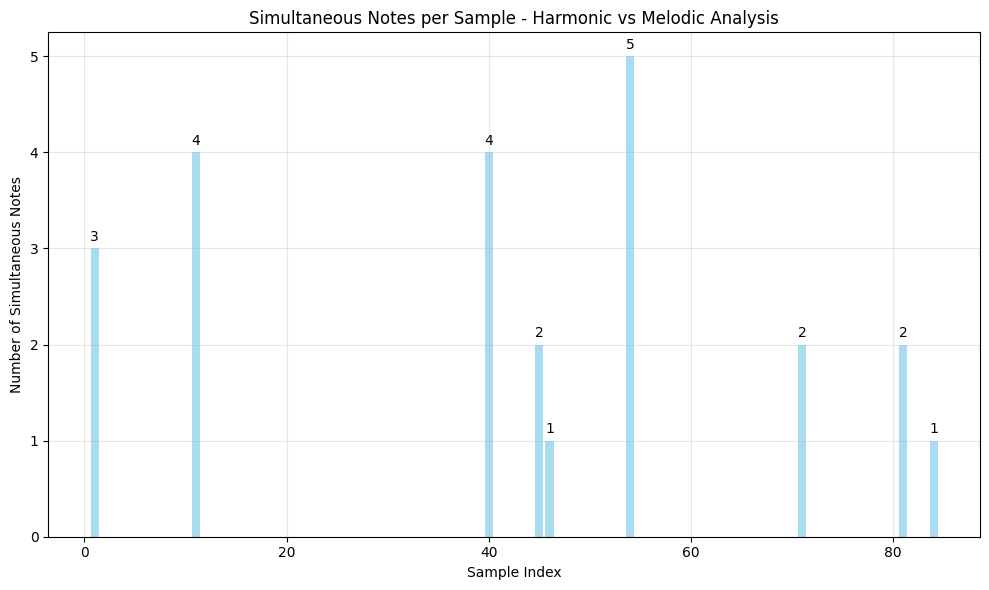

In [14]:

# Selecting 10 sampples
np.random.seed(42)  # We set a seed

n_samples = 10
max_index = 100  # taking only the first 100 to choose from assuming uniform distribution of labels and features, small subset is representative
samples_to_plot = np.random.choice(np.arange(1, max_index+1), size=n_samples, replace=False)

def analyze_note_patterns(labels, idx):
    """Analyze note patterns in a sample"""
    active_notes = np.where(labels == 1)[0]
    
    if len(active_notes) == 0:
        print(f"[Sample {idx}] No active notes.")
        return None
    
    print(f"[Sample {idx}] {len(active_notes)} notes: {active_notes} -> {'HARMONIC' if len(active_notes) >= 2 else 'MELODIC'}")
    
    return {
        'notes': active_notes,
        'count': len(active_notes)
    }

# Analyze each sample
sample_data = {}
for idx in samples_to_plot:
    labels = Ytest[idx]
    result = analyze_note_patterns(labels, idx)
    if result:
        sample_data[idx] = result

# Plot: number of notes
plt.figure(figsize=(10, 6))
indices = list(sample_data.keys())
note_counts = [sample_data[idx]['count'] for idx in indices]
bars = plt.bar(indices, note_counts, color='skyblue', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Number of Simultaneous Notes')
plt.title('Simultaneous Notes per Sample - Harmonic vs Melodic Analysis')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, note_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Histogram of played notes

In the creating of the model we will have to take a look at unbalanced classes. Therefore I will plot some statistics about that here.

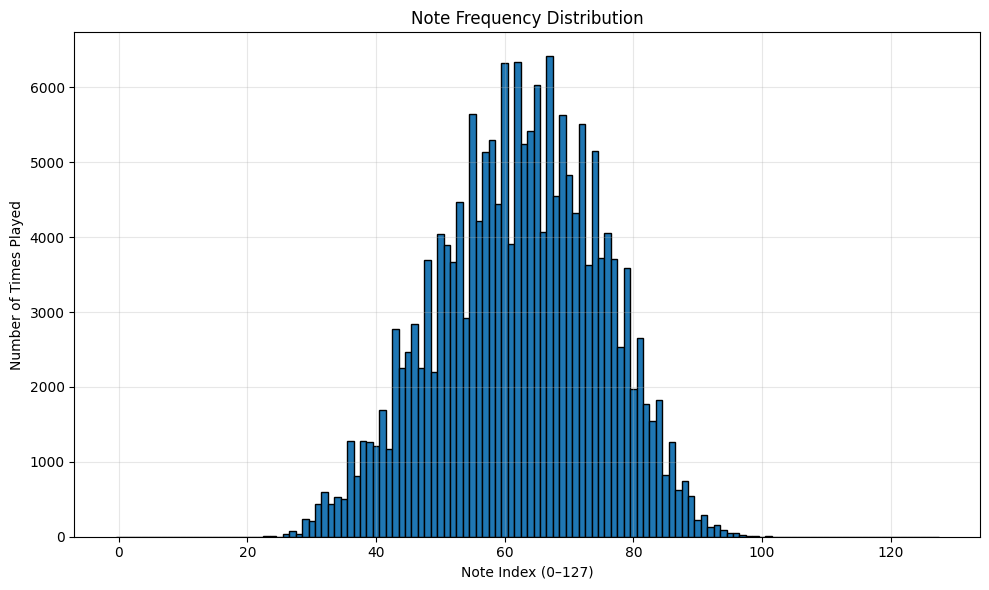

In [15]:

plt.figure(figsize=(10, 6))
plt.bar(range(128), Ytrain.sum(axis=0), width=1.0, edgecolor='black')
plt.title('Note Frequency Distribution')
plt.xlabel('Note Index (0–127)')
plt.ylabel('Number of Times Played')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


From the note frequency distribution we see that there is a class imbalance when it comes to the played notes. This means that we will have to adress this issue. Let us first get some information about distributions

In [16]:
note_counts = Ytrain.sum(axis=0)
mean_count = note_counts.mean()
std_count = note_counts.std()
median_count = np.median(note_counts)
min_count = note_counts.min()
max_count = note_counts.max()
num_zeros = np.sum(note_counts == 0)

print(f"Mean: {mean_count:.2f}")
print(f"Std: {std_count:.2f}")
print(f"Median: {median_count:.2f}")
print(f"Min: {min_count:.0f}")
print(f"Max: {max_count:.0f}")
print(f"Number of unused notes (zero count): {num_zeros}")


Mean: 1436.43
Std: 1965.24
Median: 142.00
Min: 0
Max: 6416
Number of unused notes (zero count): 48


To begin with the distribution is heavily skewed. The mean and the median are very different. Therefore, we have some notes that dominate the dataset. Forom the high standard deviation which is even bigger than the mean we conclude also that there is strong inbalance. And on top of all that there are 48 notes that are never being played. **This means we are wasting capacity trying to predict notes that never occur.**

## Overview
What we did up to this point was to read the information from the MiniNet data set, do some EDA, we showed that the data is normalized, we looked at some charactaristics of the data such as frequency ranges, mean amplitude, variance, skewness, RSM. We also explained why spectograms might be a useful way of displaying the data and how they contain more information.

# Deep learning model
In this part, after examining the data for classical music that we have I am going try and train a model to transcribe the music.

## Preprocessing the data

To begin with, I am going to normalize the features so that they have a mean of 0 and a standard deviation of 1. This is an important preprocessing step when working with neural networks, as it helps improve convergence during training and ensures that the network treats all input features on a comparable scale. Without normalization, features with larger values could dominate the learning process, potentially leading to suboptimal results.

In [17]:
Xtrain_norm = (Xtrain - np.mean(Xtrain, axis=1, keepdims=True)) / np.std(Xtrain, axis=1, keepdims=True)
Xtest_norm = (Xtest - np.mean(Xtest, axis=1, keepdims=True)) / np.std(Xtest, axis=1, keepdims=True)
Xval_norm = (Xvalid - np.mean(Xvalid, axis=1, keepdims=True)) / np.std(Xvalid, axis=1, keepdims=True)


The next things we ought to do is to convert all this information into PyTorch tensors so that we can work with them. The library I am going to use is `PyTorch`.

In [18]:

# Convert to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain_norm, dtype=torch.float32)
Ytrain_tensor = torch.tensor(Ytrain, dtype=torch.float32)
Xtest_tensor = torch.tensor(Xtest_norm, dtype=torch.float32)
Ytest_tensor = torch.tensor(Ytest, dtype=torch.float32)
Xval_tensor   = torch.tensor(Xval_norm, dtype=torch.float32)
Yval_tensor   = torch.tensor(Yvalid, dtype=torch.float32)


We use a DataLoader with TensorDataset to efficiently feed our training data to the model in manageable batches, which helps optimize memory usage and accelerates training by enabling mini-batch gradient descent. Setting shuffle=True ensures that the model sees the data in a different order each epoch, which helps prevent overfitting and improves generalization.


In [19]:
# Create DataLoaders
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Building a nerual network

In this next part, I am going to start training a network to predict which notes are being played. One of the key challenges now is deciding how to structure the network and what types of layers to include. **To begin with, we will build a typical feedforward network (Multilayer Perceptron), where we progressively reduce the dimensionality of the data. We'll use ReLU activation functions to introduce non-linearity and Dropout layers to help prevent overfitting.**

The reason I am choosing to use a MLP is because of the shortness of the samples. They do not allow for long-term temporal dependencies. The model is able to directly model the mapping from the features while being computationally efficient.

This model is a simple **feedforward neural network** designed for **multi-label classification**. It takes in **flattened input vectors of size 4096**, which are assumed to represent features extracted from audio.

## Model Architecture

- **Input layer:** 4096 features — represents the flattened audio input.
- **First hidden layer:** 512 neurons with **ReLU** activation  
  - This layer reduces the high-dimensional input to a more manageable representation while capturing important patterns.
- **Dropout layer:** with a probability of 0.3 applied after the first hidden layer  
  - Helps prevent overfitting by randomly deactivating neurons during training.
- **Second hidden layer:** 256 neurons with **ReLU** activation  
  - Further compresses and refines the learned features.
- **Dropout layer:** again with probability 0.3 applied after the second hidden layer.
- **Output layer:** 128 neurons — one for each possible note in the output  
  - Each neuron predicts the probability that the corresponding note is active.
- **Sigmoid activation:** applied to each output neuron  
  - Converts raw outputs into probabilities between 0 and 1, suitable for multi-label classification.

### Loss Function

We use `BCELoss` (Binary Cross-Entropy Loss) because this is a **multi-label binary classification problem** -  
each note can independently be either active (1) or inactive (0), so the model predicts a probability for each note.

This architecture balances complexity and efficiency, providing enough capacity to learn meaningful audio feature patterns while avoiding overfitting through dropout regularization.


In [20]:
# Define model
class TranscriptionModel(nn.Module):
    def __init__(self, input_size=4096, hidden_size1=512, hidden_size2=256, output_size=128):
        super(TranscriptionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x



before training I will first set a seed.

In [21]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


Epoch 1/10, Train Loss: 0.0891
Epoch 2/10, Train Loss: 0.0701
Epoch 3/10, Train Loss: 0.0670
Epoch 4/10, Train Loss: 0.0655
Epoch 5/10, Train Loss: 0.0643
Epoch 6/10, Train Loss: 0.0634
Epoch 7/10, Train Loss: 0.0628
Epoch 8/10, Train Loss: 0.0621
Epoch 9/10, Train Loss: 0.0616
Epoch 10/10, Train Loss: 0.0610


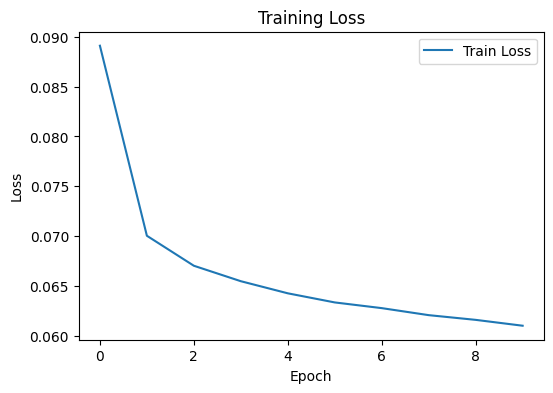

Model saved to transcription_model.pt


In [22]:

# Initialize model, loss, and optimizer
model = TranscriptionModel()
criterion = nn.BCELoss()  # Binary cross-entropy for multi-label
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # trying to use the GPU is available
        optimizer.zero_grad() # not using some features that are not needed for training
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")


# Plot training history
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save
torch.save(model.state_dict(), "transcription_model.pt")
print("Model saved to transcription_model.pt")


## Evaluation


In multi-label classification tasks like music transcription, where the model predicts which notes are active in an audio frame, accuracy alone is often insufficient. This is because most notes are inactive in any given frame, so a naive model could predict all zeros and still get high accuracy.

To better understand model performance, we use the following metrics:

| Metric    | Description                                                                                           | Relevance in Music Transcription                          |
|-----------|---------------------------------------------------------------------------------------------------|----------------------------------------------------------|
| Precision | The ratio of correctly predicted active notes to all notes predicted as active.                   | Measures how many predicted notes are actually correct.  |
| Recall    | The ratio of correctly predicted active notes to all true active notes.                           | Measures how well the model finds all active notes.       |
| F1-Score  | The harmonic mean of Precision and Recall, balancing both metrics.                               | Useful when we want a balance between detecting notes and avoiding false alarms. |
| Accuracy  | The ratio of correct predictions (both active and inactive) to all predictions.                   | Can be misleading in imbalanced data like note activity. |

**Why these matter for us:**  
In music transcription, missing an active note (low recall) means the model fails to detect a real sound. Predicting too many notes that aren't actually played (low precision) means the transcription contains false notes. The F1-score helps balance these two.


In [23]:
 #Initialize and load the saved model state
model = TranscriptionModel()
model.load_state_dict(torch.load("transcription_model.pt", map_location='cpu'))  # or map_location=device
model.to(device)
model.eval()

# 3. Evaluate on test set
with torch.no_grad():
    Xtest_tensor = Xtest_tensor.to(device)
    outputs = model(Xtest_tensor)

    # Binarize predictions at threshold 0.5
    Ypred = (outputs > 0.5).cpu().numpy()

# 4. Calculate metrics
Ytrue = Ytest  # make sure this is in NumPy format

f1 = f1_score(Ytrue, Ypred, average='micro')
acc = accuracy_score(Ytrue, Ypred)
recall = recall_score(Ytrue, Ypred, average='micro')
precision = precision_score(Ytrue, Ypred, average='micro')

# 5. Print all metrics
print(" Evaluation Metrics on Test Set:")
print(f"F1 Score:     {f1:.4f}")
print(f"Accuracy:     {acc:.4f}")
print(f"Recall:       {recall:.4f}")
print(f"Precision:    {precision:.4f}")

 Evaluation Metrics on Test Set:
F1 Score:     0.3449
Accuracy:     0.1086
Recall:       0.2321
Precision:    0.6713


### Interpretation

It is extremely important now to interpret the result we got. Firstly, we need to keep in mind the fact that we are working with multiclass data. For very sparse multi-label, F1 around 0.3-0.4 is often expected unless you tune and train a lot more. 

To understand that we need to keep in mind that random guessing performs terribly. If the model predicts every label with 0.5 probability, it will often guess 50–60 positives per sample.

- But only 2 of those are actually correct.

- Precision and recall crash → F1 near 0.01–0.05

Also if we look at empirical evidence (from papers and practice) in multi-label music tagging, audio tagging, or multi-label NLP, where positives are rare:

- **Baseline F1 often sits around 0.3 to 0.4**

- **Very good models with heavy tuning reach 0.5–0.6**



Considering the precision and recall independantely, we see that 2/3 f the time we classify a note correctly and 1/4 of the notes have been catched. This however is not perfect.

A study showing results, which are proving this has been linked in the resources.

### Looking into examples 

Now, let us go through some of the samples and see if we can get a feel of what is going on.

In [24]:

for i in range(0,20):
    mask = (model(Xtest_tensor)[i] > 0.5)
    indices = torch.nonzero(mask).squeeze().cpu().numpy()

    true_positive_indices = np.where(Ytest[i] == 1)[0]
    print(f"guess: {indices}, real: {true_positive_indices}")


guess: [], real: [62 74]
guess: [], real: [46 58 67]
guess: [], real: [62 70]
guess: [], real: [45 57 66]
guess: 69, real: [62 69]
guess: 55, real: [43 55 70]
guess: 70, real: [62 70]
guess: [], real: [45 57 69]
guess: [57 65], real: [62 65]
guess: [], real: [38 50 74]
guess: [57 62], real: [38 50]
guess: 65, real: [62 65 69 74]
guess: 76, real: [61 64 69 76]
guess: [69 81], real: [61 64 69 81]
guess: 77, real: [62 65 69 77]
guess: [65 69], real: [62 65 69 81]
guess: [], real: []
guess: [60 62 81], real: [60 62 66 81]
guess: 58, real: []
guess: [67 70], real: [67 70 82]


We have to also get a musical understanding of the notes we are getting. We are going to make a function taking a label and transform it to a note.

In [25]:

for i in range(10, 20):
    output = model(Xtest_tensor[i].unsqueeze(0))  # [1, 128]
    pred_mask = (output > 0.5).squeeze().cpu().numpy()
    pred_indices = np.where(pred_mask == 1)[0]

    true_indices = np.where(Ytest[i] == 1)[0]

    # Set operations
    true_set = set(true_indices)
    pred_set = set(pred_indices)

    true_positives = sorted(true_set & pred_set)
    false_negatives = sorted(true_set - pred_set)
    false_positives = sorted(pred_set - true_set)

    # Convert to note names
    tp_notes = [librosa.midi_to_note(n) for n in true_positives]
    fn_notes = [librosa.midi_to_note(n) for n in false_negatives]
    fp_notes = [librosa.midi_to_note(n) for n in false_positives]

    print(f" Sample {i}")
    print(f"  True Positives (correct):   {true_positives} -> {tp_notes}")
    print(f"  False Negatives (missed):   {false_negatives} -> {fn_notes}")
    print(f"  False Positives (extra):    {false_positives} -> {fp_notes}")
    print()


 Sample 10
  True Positives (correct):   [] -> []
  False Negatives (missed):   [38, 50] -> ['D2', 'D3']
  False Positives (extra):    [57, 62] -> ['A3', 'D4']

 Sample 11
  True Positives (correct):   [65] -> ['F4']
  False Negatives (missed):   [62, 69, 74] -> ['D4', 'A4', 'D5']
  False Positives (extra):    [] -> []

 Sample 12
  True Positives (correct):   [76] -> ['E5']
  False Negatives (missed):   [61, 64, 69] -> ['C♯4', 'E4', 'A4']
  False Positives (extra):    [] -> []

 Sample 13
  True Positives (correct):   [69, 81] -> ['A4', 'A5']
  False Negatives (missed):   [61, 64] -> ['C♯4', 'E4']
  False Positives (extra):    [] -> []

 Sample 14
  True Positives (correct):   [77] -> ['F5']
  False Negatives (missed):   [62, 65, 69] -> ['D4', 'F4', 'A4']
  False Positives (extra):    [] -> []

 Sample 15
  True Positives (correct):   [65, 69] -> ['F4', 'A4']
  False Negatives (missed):   [62, 81] -> ['D4', 'A5']
  False Positives (extra):    [] -> []

 Sample 16
  True Positives (cor

What we see from that is that there are all different combinations in each of the samples. There are samples that contain no notes up to 4 notes. From our results we were able to predict a note that is contained in the true notes, however not always, with many false negatives, some true positives and rarely false possitives.

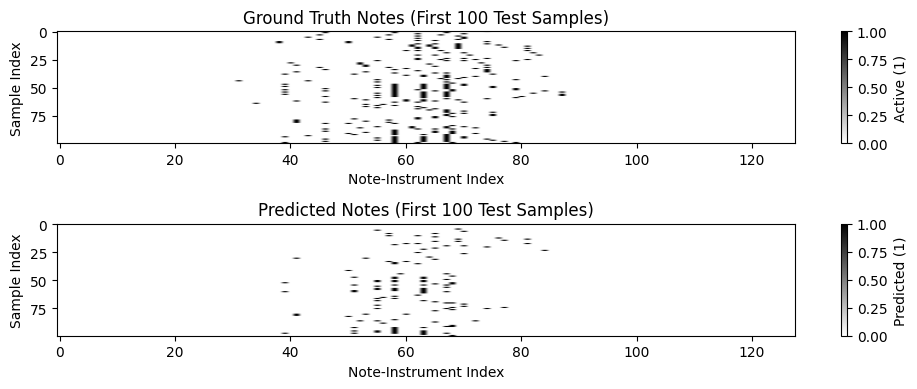

In [26]:
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.imshow(Ytest[:100], aspect='auto', cmap='binary')
plt.title("Ground Truth Notes (First 100 Test Samples)")
plt.xlabel("Note-Instrument Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Active (1)")
plt.subplot(2, 1, 2)
plt.imshow(Ypred[:100], aspect='auto', cmap='binary')
plt.title("Predicted Notes (First 100 Test Samples)")
plt.xlabel("Note-Instrument Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Predicted (1)")
plt.tight_layout()
plt.show()

## Possible optimizations

Some things that might improve the model's performance are:
-  **Remove unused labels** (notes with zero counts).
-  **Reduce output dimension** and filtere training labels accordingly.
-  **Use Focal Loss** to handle extreme class imbalance.
-  **Adjuste prediction thresholds** to make the model more recall-sensitive.


# Looking at modern music

## EDA

In this second part of the project my goal is to take a look at the "babyslakh_16k" dataset which is the smaller version. I will begin by doing some EDA where I will try to understand the structure of the dataset(how long the audio files are, how many they are, what is the Hz, if they contain recordings of 1 or many different music instruent, etc.) Doing so I also aim to understand what the best way to model the dataset is as well as define a task. To begin with, we have 20 track folders containing many files. In each folder we have:
-`all_src.mid`
The original **Lakh MIDI** file containing all possible MIDI sources for that track.

-Individual MIDI stems (`S00.mid`, `S01.mid`, …)
Per-instrument MIDI files actually used to synthesize each isolated stem.  
These represent the separated MIDI data for each instrument in the mix.

-`mix.wav`
The **final mixture** created by summing all stems together.  
In **BabySlakh_16k**, this is rendered at a 16 kHz WAV format  
(in the full Slakh2100 dataset, it is stored as FLAC).

- `metadata.yaml`
    A structured metadata file describing the track, including:
    * **UUID** – Unique identifier of the original Lakh MIDI.
    * **audio_dir**, **midi_dir** – Directories for stems and MIDI files (e.g., `"stems"`, `"MIDI"`).
    * **Normalization parameters** – e.g., `normalized`, `overall_gain`.
    * **Stems metadata** – For each stem (`S00`, `S01`, …), contains:
      - `inst_class` – Instrument class.
      - `plugin_name` – Plugin used for rendering.
      - `program_num` – MIDI program number.
      - `integrated_loudness` – Loudness in LUFS.
      - `is_drum` – Boolean flag indicating whether the stem is percussion.

- `stems/` folder
Contains the **isolated audio stems** for each instrument in the track,  
rendered as individual WAV files at 16 kHz sample rate.

I am going to begin by defining a couple of function that might be useful for the analysis. Before beginning I will define some constants that we are going to need. After that I am going to define a couple function.
1. Firstly, define a function that is going to get the track duration given an audio path. This will be needed so that we can find the average duration of the files.
2. Secondly, We define a function that, given a midi_folder of a track, extracts all of the pitches from all of the instruments and adds them into an array. This part could be interpreted in different ways. We could have different array, for different instruments and see which instruments are played the most compared to others and in which region they are played. However for now I will keep this simple version of tracking all of the pitches at one place
3. Define a function that uses the prior 2 functions to extract durations and pitches from all tracks.
4. Define a function that plots a histogram with given parameters.

## Hypothesis for pitch and duration
### 1. Track duration distribution

**Null Hypothesis (H₀):**  
The distribution of track durations is uniform or random without a significant central tendency around typical modern music lengths.
**Alternative Hypothesis (H₁):**  
The distribution of track durations shows a significant concentration within the typical modern music range of 3 to 5 minutes.


**Testing Approach:**  
- Use a Chi-square goodness-of-fit test to compare the observed distribution of track durations to a uniform or expected distribution.  
- Alternatively, analyze descriptive statistics such as mean, median, and confidence intervals to determine if the central tendency lies within the hypothesized range.



### 2. Pitch distribution across tracks

**Null Hypothesis (H₀):**  
Pitch values are uniformly distributed across the pitch range, indicating no preference or concentration in any register.

**Alternative Hypothesis (H₁):**  
Pitch values are significantly concentrated in the midrange registers, corresponding to typical musical instruments and vocals.

**Testing Approach:**  
- Apply a Chi-square goodness-of-fit test to compare observed pitch frequencies against a uniform distribution.  
- Perform modality tests or cluster analysis to detect and confirm significant peaks in the pitch histogram.


In [27]:
SR = 16000
BASE_FOLDER = 'babyslakh_16k'

In [28]:
def get_track_duration(audio_path):
    """Load an audio file and return its duration"""
    waveform, sr = torchaudio.load(audio_path)
    return waveform.shape[1] / sr

In [29]:
def get_pitches_from_midi(midi_folder):
    """Extract all note pitches from all MIDI files in a folder."""
    pitches = []
    midi_files = [f for f in os.listdir(midi_folder) if f.endswith('.mid')]
    
    for midi_file in midi_files:
        pm = pretty_midi.PrettyMIDI(os.path.join(midi_folder, midi_file))
        for inst in pm.instruments:
            pitches.extend([note.pitch for note in inst.notes])
    
    return pitches

In [30]:
def process_all_tracks(base_folder, track_range=range(1, 21)):
    """Go through each track folder and collect durations and pitches."""
    durations = []
    all_pitches = [] # keeping all pitches together, no matter the instrument

    for i in track_range:
        track_id = f"Track{str(i).zfill(5)}" # I am adding zeros because of the name format of the files
        track_folder = os.path.join(base_folder, track_id)

        # 1) Duration from mix.wav
        audio_path = os.path.join(track_folder, 'mix.wav')
        if os.path.exists(audio_path):
            durations.append(get_track_duration(audio_path))
        else:
            print(f"Missing audio for {track_id}")

        # 2) Pitches from MIDI files
        midi_folder = os.path.join(track_folder, 'MIDI')
        if os.path.exists(midi_folder):
            all_pitches.extend(get_pitches_from_midi(midi_folder))
        else:
            print(f"Missing MIDI for {track_id}")

    return durations, all_pitches


In [31]:
def plot_histogram(data, bins, title, xlabel, ylabel, color):
    """Plot a histogram of given data."""
    plt.hist(data, bins=bins, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


Processed 20 tracks
Average duration: 243.37 seconds
Min duration: 160.62 seconds
Max duration: 347.75 seconds
Median duration: 243.95 sec
Standard deviation: 46.13 sec


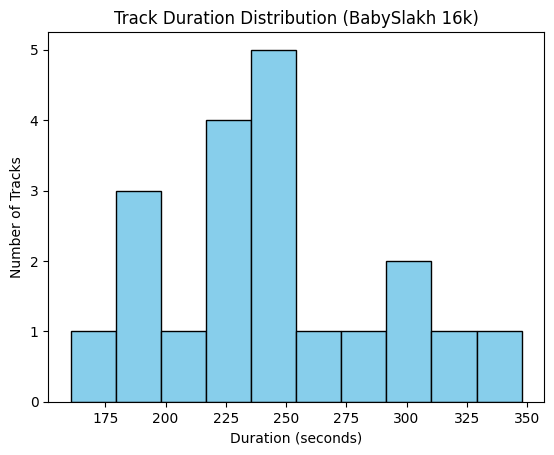

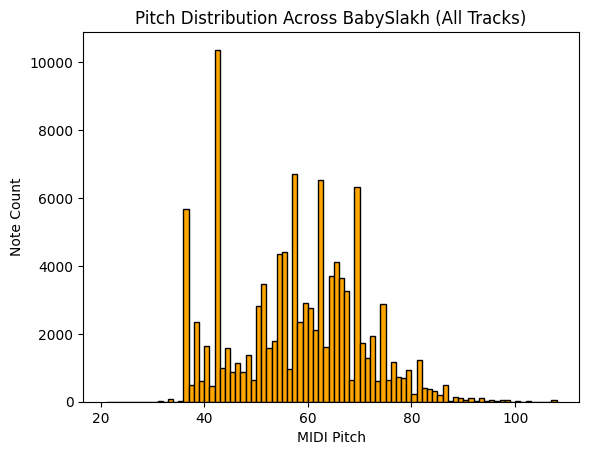

In [32]:
durations, all_pitches = process_all_tracks(BASE_FOLDER)

print(f"Processed {len(durations)} tracks")
print(f"Average duration: {np.mean(durations):.2f} seconds")
print(f"Min duration: {np.min(durations):.2f} seconds")
print(f"Max duration: {np.max(durations):.2f} seconds")
print(f"Median duration: {np.median(durations):.2f} sec")
print(f"Standard deviation: {np.std(durations):.2f} sec")

    # Duration distribution
plot_histogram(
    durations, bins=10,
    title="Track Duration Distribution (BabySlakh 16k)",
    xlabel="Duration (seconds)", ylabel="Number of Tracks",
    color="skyblue"
)

# Pitch distribution
plot_histogram(
    all_pitches, bins=np.arange(21, 109),
    title="Pitch Distribution Across BabySlakh (All Tracks)",
    xlabel="MIDI Pitch", ylabel="Note Count",
    color="orange"
)

### Track duration distribution

- To begin with, we see that the durations of almost half the files are between 220 and 255 seconds. This corresponds to about 3.7 to 4.3 minutes, which aligns well with typical modern music lengths.  
- Descriptive statistics for the 20 tracks:  
  - **Average duration:** 243.37 seconds  
  - **Median duration:** 243.95 seconds  
  - **Minimum duration:** 160.62 seconds  
  - **Maximum duration:** 347.75 seconds  
  - **Standard deviation:** 46.13 seconds  

- There are some shorter tracks (around 160–200 seconds) as well as longer ones (above 300 seconds), indicating some variety. The distribution appears to be slightly right-skewed due to these longer tracks.  
- From a preprocessing perspective, the variation in track lengths is not substantial enough to require fundamentally different handling for the shortest and longest tracks. Even though the longest track is roughly twice the duration of the shortest, this range is relatively small for most algorithms, meaning the same preprocessing pipeline can be applied consistently across all files.

### Pitch distribution across all tracks

- Firstly, we see that the histogram shows some strong peaks in certain regions:  
    - 40–50: lower register (bass, drums)  
    - 60–70: mid register (guitar, piano, vocals)  
- Few notes occur above pitch 90.  
- All this suggests that the dataset is **centered in the midrange**, which is expected.


We can **reject our null hypothesis**, seeing that the mean and median are almost the same around 4 minutes with a standard deviation of 46 seconds. This fits almost perfectly our range of 3 to 5 minutes for a song. 

Similarly, for pitch distribution, we can reject the null hypothesis of a uniform distribution. The observed pitch histogram shows distinct peaks at certain pitch ranges, indicating that some pitches occur much more frequently than others, reflecting common musical structure rather than random pitch usage.

## Extracting spectral centroid, spectral bandwidth, tempo

As for this part of the analysis I will try to extract some more important features before jumping into the modeling part.

### Spectral centroid
The spectral centroid is a key audio feature that represents the "center of mass" of the spectrum, essentially indicating where the bulk of the signal’s frequency energy is concentrated. It is often interpreted as a measure of the brightness of a sound. This would mean that if most tracks have higher spectral centroids that means that there might be some sharper or brighter sounds. A lower spectral centroid on the other side, corresponds to darker, bass-heavy sounds.
### Spectral bandwidth
Spectral bandwidth measures the spread or range of frequencies around the spectral centroid in an audio signal. It essentially captures how wide or narrow the frequency content is distributed around the center of mass. This would suggest that a **larger spectral bandwidth** means a wider range of frequencies, meaning a more complex noisier sound. **A smaller spectral bandwitdth**  suggests narrower frequency spread, typical of pure tones or simple harmonic sounds.
### Tempo
Tempo refers to the speed or pace of a piece of music, usually measured in beats per minute (BPM). It represents how fast the underlying rhythmic pulse occurs and is a fundamental aspect of a song’s feel and style.

Now I am going to define a function which aims to extract those features from the data we have. But before doing so, let us form our hypothesis which will not be as formal for this case.
### Hypothesis

1. **Spectral Centroid** – Expected to predominantly range between **1500 Hz and 3500 Hz**, indicating generally bright tonal qualities typical of modern music.  
2. **Spectral Bandwidth** – Expected to lie between **1000 Hz and 4000 Hz**, reflecting moderate to wide timbral complexity.  
3. **Tempo (BPM)** – Expected to be mostly between **80 BPM and 130 BPM**, consistent with common tempos in popular music.


In [33]:
def extract_audio_features(base_folder, track_range=range(1, 21)):
    
    spectral_centroids = []
    spectral_bandwidths = []
    tempos = []

    for i in track_range:
        track_id = f"Track{str(i).zfill(5)}" # again becuase of the name formating 
        audio_path = os.path.join(base_folder, track_id, 'mix.wav')
        
        if os.path.exists(audio_path):
            y, sr = librosa.load(audio_path, sr=SR)

            # Spectral centroid
            cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroids.append(np.mean(cent))

            # Spectral bandwidth
            bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            spectral_bandwidths.append(np.mean(bandwidth))

            # Tempo estimation
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            tempo = rhythm.tempo(onset_envelope=onset_env, sr=sr)
            tempos.append(tempo[0]) # The first one is the most likely

        else:
            print(f"Missing audio for {track_id}")

    return spectral_centroids, spectral_bandwidths, tempos



Having the features we will plot some important information as well as the histograms.

Spectral Centroid - Mean: 1317.32, Std: 210.74
Spectral Bandwidth - Mean: 1514.76, Std: 189.01
Tempo (BPM) - Mean: 116.66, Std: 18.51


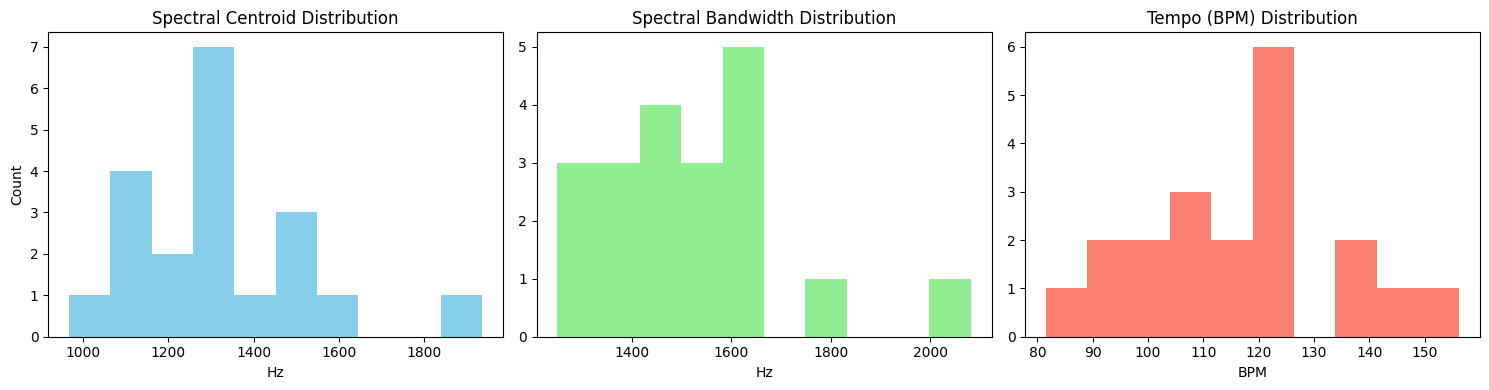

In [34]:
spectral_centroids, spectral_bandwidths, tempos = extract_audio_features(BASE_FOLDER)

spectral_centroids = np.array(spectral_centroids) # transforming them to np.arrays for easier work
spectral_bandwidths = np.array(spectral_bandwidths)
tempos = np.array(tempos)

print(f"Spectral Centroid - Mean: {np.mean(spectral_centroids):.2f}, Std: {np.std(spectral_centroids):.2f}")
print(f"Spectral Bandwidth - Mean: {np.mean(spectral_bandwidths):.2f}, Std: {np.std(spectral_bandwidths):.2f}")
print(f"Tempo (BPM) - Mean: {np.mean(tempos):.2f}, Std: {np.std(tempos):.2f}")

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(spectral_centroids, bins=10, color='skyblue')
plt.title('Spectral Centroid Distribution')
plt.xlabel('Hz')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(spectral_bandwidths, bins=10, color='lightgreen')
plt.title('Spectral Bandwidth Distribution')
plt.xlabel('Hz')

plt.subplot(1,3,3)
plt.hist(tempos, bins=10, color='salmon')
plt.title('Tempo (BPM) Distribution')
plt.xlabel('BPM')

plt.tight_layout()
plt.show()


### Observed Results and Comparison

1. **Spectral Centroid** – Mostly ranges from approximately **1000 Hz to 1900 Hz**, which is notably lower than expected, suggesting darker or bass-heavy tonal qualities.  
2. **Spectral Bandwidth** – Ranges from about **1300 Hz to 2100 Hz**, fitting well within the hypothesized range, indicating moderate spectral spread and consistent timbral complexity.  
3. **Tempo (BPM)** – Mainly falls between **85 BPM and 155 BPM**, aligning well with the hypothesis, though some faster outliers are present.

## Deep learning model

Now we are faced with the task of creating a model that can transcribe this music. We were able to explore a little bit about what could be useful when creating a neural network when working with audio files. However, with this task of modern music and having a different dataset with a different structure we are also faced with different problems.
### Chalanges
1. To begin with, we are working with less and longer files. This means that for the training of the model we will need separate the files into chunks.
2. Secondly, we will have to decide if we are going to treat different instruments differently or all the same.
3. After we are ready with the preprocessing we have to decide on the type of neural network we are going to use. In the last task with classical music we showed a couple of different options and discussed which one is the best for our type of problem.

## Execution plan
1. Define constants
2. Define a function that loads an audio file and converts it to mono for simplicity
3. Define a function that is computing the mel spectogram(in our earlier task we defined one but there are some other things we need to account and I am not reusing it)
4. Define a function that merges MIDI files for each track and then convert them to piano rolls so that we can use them during training.
5. Define a function that makes the data into chunks
6. Define a function that goes through the whole process using the upper functions
7. Define a function that runs through all of the tracks

### Constants and justification

We are going to define constants for easier work. I am also going to give insight as to why I choose those specific constants. We will have:
1. `SR`: This is coming from the files, we know that the sampling rate is 16kHz
2. `CHUNK_SEC`: This is going to be the duration of each chunk. I am using 5 seconds since it is not too long but also allows for chords and melodies.
3. `N_MELS`: When we convert to mel-spectogram we are mappin the frequencies to the mel scale(we already discussed that) that we will represent using 64 bins. It gives us a wide enough range transcription.
4. `N_FFT`: At our 16 kHz SR thi means 128 of audio which is enough to reslove frequencies clearly. A smaller window would mean better time resolution but worse frequency resolution.
5. `HOP_LENGTH`: I am going to use a smaller `HOP_LENGTH` so that there could be overlapping which is good for smoothness.
6. `PITCH_RANGE`: This range will ensure that we only take a piano range and ignore frequencies outside of that. If we wanted to take consideration of each independent instrument we would define a different pitch range for each instrument but since we are converting everything to piano rolls we use a unified range.
7. `PIANO_ROLL_FS`: We are doing this to align the the rates of the mel spectogram frames and the piano rolls for direct mapping later on. This would avoid interpolation.

In [35]:
# Constants
SR = 16000
CHUNK_SEC = 5 
N_MELS =88
N_FFT = 2048
HOP_LENGTH = 1024
PITCH_RANGE = (21, 108)
PIANO_ROLL_FS = SR / HOP_LENGTH # Frame rate, frames per second

CHUNK_FRAMES = int(CHUNK_SEC * PIANO_ROLL_FS)# Getting the number of frames per chunk
#This is going to be one of the dimensions of the chunk data.


### Audio loading


In [36]:
# Function to load audio as mono numpy array
def load_audio(audio_path, sr=SR):
    
    """This function takes an audio path and converts the waveform into mono
    since it is easier to process in a model later on."""
    
    waveform, orig_sr = torchaudio.load(audio_path)
    waveform = waveform.mean(dim=0).numpy()  # mono
    return waveform


### Compution a mel spectogram and piano rolls

In [37]:

def compute_full_mel_spectrogram(audio, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=N_MELS,
        power=2.0
    )
    mel_db = librosa.power_to_db(mel_spec, ref=np.max) # Decibels better match human loudness perception and make it more suitable for neural networks
    return mel_db.T  # We want the shape to be (frames,n_mels) since models often expect time as first dimension and it should also align the piano roll

Unlike the task with classical music, now we are working with MIDI files and not direct labels. This means that we need to transform the MIDI files in order to get meaningful information from them for the training. Now I am going to define two functions. The first one is taking a MIDI file and transform it to a piano roll (time_steps, pitches) which are more appropriate for training. The second one is running through all the files and saving the new files as `.npy`

In [38]:

def compute_full_piano_roll(pm, fs=PIANO_ROLL_FS, pitch_range=PITCH_RANGE):
    """This is computing piano rolls from PrettyMIDI merged data"""
    pr = pm.get_piano_roll(fs=fs)  # (128, time_frames)
    min_pitch, max_pitch = pitch_range
    pr = pr[min_pitch:max_pitch+1, :] # only take those in our range
    pr_binary = (pr > 0).astype(np.float32) # Converting velocity to 1 or 0 since we are interested in whether the note is active or not
    return pr_binary.T  # again we want the frames to be first

### Chunks and processing

We we will define the function which is going to chunck a feature array. We say feature array since we are going to use this function both for the piano rolls and for the mel spectogram. There is one specific in the function. When the last chunk is smaller than the previos ones we must process the missing frames. We are doing this by padding with zeros. We can do this since **the model is going to learn to ignore those zeros.**

In [39]:
# Chunk features into fixed-length frame chunks, pad last chunk if needed
def chunk_features(feature_array, chunk_len=CHUNK_FRAMES):
    chunks = []
    total_frames = feature_array.shape[0] # Our data is (time_frames,feature_dim)
    for start in range(0, total_frames, chunk_len):
        end = start + chunk_len
        chunk = feature_array[start:end]
        if chunk.shape[0] < chunk_len:
            pad_width = ((0, chunk_len - chunk.shape[0]), (0, 0)) # This is padding with zeros if the last chunk is smaller
            chunk = np.pad(chunk, pad_width, mode='constant')
        chunks.append(chunk)
    return chunks


### Preprocessing function
Now that we have defined our helper functions we have to define one that takes a track and preprocesses it correctly. We are going to:
- Loading the audio and its corresponding MIDI data
- Merging all MIDI files in the track
- Computing the mel spectrogram and piano roll features
- Aligning their lengths
- Splitting them into fixed-length chunks
- Saving those chunks as `.npy` files to disk for later training


I will mention once again that we are going to merge all of the MIDI files for an instrument into one MIDI file for each track. 

In [40]:


def process_and_chunk_track(track_path, save_dir_mel, save_dir_pr):
    audio_path = os.path.join(track_path, "mix.wav")
    if not os.path.isfile(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")
    print(f"Loading audio from: {audio_path}")
    
    midi_folder = os.path.join(track_path, "MIDI")
    if not os.path.isdir(midi_folder):
        raise FileNotFoundError(f"MIDI folder not found: {midi_folder}")
    
    midi_files = [os.path.join(midi_folder, f) for f in os.listdir(midi_folder) if f.endswith('.mid')]
    if len(midi_files) == 0:
        raise FileNotFoundError(f"No MIDI files found in {midi_folder}")
        
    # Merging MIDI files
    merged_pm = pretty_midi.PrettyMIDI()
    for midi_file in midi_files:
        pm = pretty_midi.PrettyMIDI(midi_file)
        for inst in pm.instruments:
            merged_pm.instruments.append(inst)

    # Load audio and compute features
    audio = load_audio(audio_path)
    mel_full = compute_full_mel_spectrogram(audio)
    pr_full = compute_full_piano_roll(merged_pm)

    # Align lengths by trimming to shortest length
    min_len = min(mel_full.shape[0], pr_full.shape[0])
    mel_full = mel_full[:min_len]
    pr_full = pr_full[:min_len]

    mel_chunks = chunk_features(mel_full)
    pr_chunks = chunk_features(pr_full)

    num_chunks = min(len(mel_chunks), len(pr_chunks))

    os.makedirs(save_dir_mel, exist_ok=True)
    os.makedirs(save_dir_pr, exist_ok=True)

    # saving the chunks
    for i in range(num_chunks):
        mel_path = os.path.join(save_dir_mel, f"chunk_{i:03d}.npy")
        pr_path = os.path.join(save_dir_pr, f"chunk_{i:03d}.npy")
        np.save(mel_path, mel_chunks[i])
        np.save(pr_path, pr_chunks[i])
    print(f"Saved {num_chunks} chunks for track {os.path.basename(track_path)}")

### Processing the whole dataset

Now we are going to go through all the tracks, split into training and testing sets and we will have all of the files we need to feed our model

In [41]:
# Process all tracks 
def process_dataset(base_folder, track_list, split_name):
    for track in track_list:
        track_path = os.path.join(base_folder, track)
        mel_save_dir = os.path.join(base_folder, 'chunks', 'mels', split_name, track)
        pr_save_dir = os.path.join(base_folder, 'chunks', 'pianorolls', split_name, track)
        process_and_chunk_track(track_path, mel_save_dir, pr_save_dir)


TRACKS = [d for d in os.listdir(BASE_FOLDER) if os.path.isdir(os.path.join(BASE_FOLDER, d)) and d.startswith('Track')]
print(f"Found {len(TRACKS)} tracks")

random.seed(0)
random.shuffle(TRACKS)

num_tracks = len(TRACKS)
num_test = 2
num_val = 2
num_train = num_tracks - num_val - num_test

train_tracks = TRACKS[:num_train]
val_tracks = TRACKS[num_train:num_train + num_val]
test_tracks = TRACKS[num_train + num_val:]

print("Train tracks:", train_tracks)
print("Validation tracks:", val_tracks)
print("Test tracks:", test_tracks)

process_dataset(BASE_FOLDER, train_tracks, 'train')
process_dataset(BASE_FOLDER, val_tracks, 'val')
process_dataset(BASE_FOLDER, test_tracks, 'test')


Found 20 tracks
Train tracks: ['Track00011', 'Track00019', 'Track00017', 'Track00015', 'Track00001', 'Track00018', 'Track00012', 'Track00003', 'Track00004', 'Track00010', 'Track00006', 'Track00008', 'Track00005', 'Track00020', 'Track00007', 'Track00016']
Validation tracks: ['Track00009', 'Track00002']
Test tracks: ['Track00014', 'Track00013']
Loading audio from: babyslakh_16k\Track00011\mix.wav
Saved 39 chunks for track Track00011
Loading audio from: babyslakh_16k\Track00019\mix.wav
Saved 46 chunks for track Track00019
Loading audio from: babyslakh_16k\Track00017\mix.wav
Saved 62 chunks for track Track00017
Loading audio from: babyslakh_16k\Track00015\mix.wav
Saved 49 chunks for track Track00015
Loading audio from: babyslakh_16k\Track00001\mix.wav
Saved 48 chunks for track Track00001
Loading audio from: babyslakh_16k\Track00018\mix.wav
Saved 59 chunks for track Track00018
Loading audio from: babyslakh_16k\Track00012\mix.wav
Saved 61 chunks for track Track00012
Loading audio from: babys

### Testing for size

In [42]:
def count_and_report_chunks(base_folder):
    splits = ['train', 'val', 'test']
    
    for split in splits:
        mel_root = os.path.join(base_folder,'chunks', 'mels', split)
        pr_root = os.path.join(base_folder,'chunks', 'pianorolls', split)
        
        print(f"--- Split: {split} ---")
        
        total_mel_chunks = 0
        total_pr_chunks = 0
        mel_shapes = set()
        pr_shapes = set()
        
        tracks = sorted(os.listdir(mel_root))
        
        for track in tracks:
            mel_track_dir = os.path.join(mel_root, track)
            pr_track_dir = os.path.join(pr_root, track)
            
            if not os.path.isdir(mel_track_dir) or not os.path.isdir(pr_track_dir):
                continue
            
            mel_files = sorted([f for f in os.listdir(mel_track_dir) if f.endswith('.npy')])
            pr_files = sorted([f for f in os.listdir(pr_track_dir) if f.endswith('.npy')])
            
            total_mel_chunks += len(mel_files)
            total_pr_chunks += len(pr_files)
            
            for mf in mel_files:
                mel_array = np.load(os.path.join(mel_track_dir, mf))
                mel_shapes.add(mel_array.shape)
                
            for pf in pr_files:
                pr_array = np.load(os.path.join(pr_track_dir, pf))
                pr_shapes.add(pr_array.shape)
        
        print(f"Total mel chunks: {total_mel_chunks}")
        print(f"Unique mel shapes: {mel_shapes}")
        print(f"Total piano roll chunks: {total_pr_chunks}")
        print(f"Unique piano roll shapes: {pr_shapes}")
        print()

count_and_report_chunks(BASE_FOLDER)


--- Split: train ---
Total mel chunks: 796
Unique mel shapes: {(78, 88)}
Total piano roll chunks: 796
Unique piano roll shapes: {(78, 88)}

--- Split: val ---
Total mel chunks: 70
Unique mel shapes: {(78, 88)}
Total piano roll chunks: 70
Unique piano roll shapes: {(78, 88)}

--- Split: test ---
Total mel chunks: 98
Unique mel shapes: {(78, 88)}
Total piano roll chunks: 98
Unique piano roll shapes: {(78, 88)}



### Dataset and Dataloader
For the Dataset we have two options. We could define a custom class which loads lazily or use the TensorDataset class which is easier but loads all data in RAM. Since the data we are working with is stored in chunks and we do not want to load it all in the RAM at once I am going to create custom class for the dataset. The custom dataset is going to take a chunk and create a dataset of it. Then in the loader I am going to go trough all the files in a track, create a dataset for each chunk, and then concat all of the datasets which then we will load.

In [43]:

class ChunkDataset(Dataset):
    def __init__(self, mel_dir, pr_dir):
        self.mel_dir = mel_dir
        self.pr_dir = pr_dir

        self.mel_files = sorted([f for f in os.listdir(mel_dir) if f.endswith('.npy')])
        self.pr_files = sorted([f for f in os.listdir(pr_dir) if f.endswith('.npy')])

        assert self.mel_files == self.pr_files, "Mismatch between mel and piano roll chunk files"

    def __len__(self):
        return len(self.mel_files)

    def __getitem__(self, idx):
        mel_path = os.path.join(self.mel_dir, self.mel_files[idx])
        pr_path = os.path.join(self.pr_dir, self.pr_files[idx])
    
        mel_chunk = np.load(mel_path)
        pr_chunk = np.load(pr_path)
    
        # Convert to tensor
        mel_tensor = torch.tensor(mel_chunk, dtype=torch.float32)
        pr_tensor = torch.tensor(pr_chunk, dtype=torch.float32)
    
        # Normalize mel spectrogram (e.g. min-max or standard)
        mel_tensor = (mel_tensor - mel_tensor.mean()) / (mel_tensor.std() + 1e-6)
    
        return mel_tensor, pr_tensor


In [44]:

def load_split_dataloader(base_folder, split='train', batch_size=16, shuffle=True, num_workers=2):
    mel_base = os.path.join(base_folder, 'chunks', 'mels', split)
    pr_base = os.path.join(base_folder, 'chunks', 'pianorolls', split)

    datasets = []
    for track in os.listdir(mel_base):
        mel_dir = os.path.join(mel_base, track)
        pr_dir = os.path.join(pr_base, track)
        if os.path.isdir(mel_dir) and os.path.isdir(pr_dir):
            ds = ChunkDataset(mel_dir, pr_dir)
            datasets.append(ds)

    full_dataset = ConcatDataset(datasets)
    loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) # Loading all of the chunks
    return loader

train_loader = load_split_dataloader(BASE_FOLDER, 'train', batch_size=16, shuffle=True, num_workers=0) # num_workers is required for cheking in the next piece of code
val_loader = load_split_dataloader(BASE_FOLDER, 'val', batch_size=16, shuffle=False, num_workers=0)
test_loader = load_split_dataloader(BASE_FOLDER, 'test', batch_size=16, shuffle=False, num_workers=0)



In [45]:
mel_batch, pr_batch = next(iter(train_loader))

print("Mel batch shape:", mel_batch.shape)      
print("Piano roll batch shape:", pr_batch.shape)  # should be (batch_size, chunk_frames, 88) as well as the previous one

print("Mel batch min/max:", mel_batch.min().item(), mel_batch.max().item())
print("Piano roll batch unique values:", torch.unique(pr_batch))

print("First mel chunk (first 5 frames):")
print(mel_batch[0, :5, :])

print("First piano roll chunk (first 5 frames):")
print(pr_batch[0, :5, :])


Mel batch shape: torch.Size([16, 78, 88])
Piano roll batch shape: torch.Size([16, 78, 88])
Mel batch min/max: -3.250497579574585 3.022968292236328
Piano roll batch unique values: tensor([0., 1.])
First mel chunk (first 5 frames):
tensor([[ 0.8439,  1.2127,  1.7208,  1.0050,  1.7256,  1.9323,  0.8381,  1.2817,
          1.4722,  0.9635,  1.6637,  1.6749,  1.3419,  1.4307,  1.4758,  0.5783,
          1.1306,  1.0608,  1.1821,  1.6065,  1.5579, -0.4833,  0.7495,  0.4042,
          0.6665,  1.3984,  0.7414, -0.3260,  0.4388, -0.0112,  0.4443,  0.4974,
         -0.0436, -0.0561, -0.0030,  0.0300,  0.3435,  0.0407,  0.1002,  0.2322,
          0.5977,  0.0703,  0.1777, -0.5791,  0.5086,  0.6342, -0.0550,  0.1411,
         -0.5256, -0.8100, -0.5348, -0.4855, -0.0062, -0.1489, -0.5105, -0.1435,
          0.1854,  0.0644, -0.6180, -0.5631, -0.7870, -0.7317, -0.9042, -1.1421,
         -1.1606, -1.3052, -1.2430, -1.2228, -1.2178, -0.7826, -0.8186, -1.2765,
         -1.1576, -1.3047, -1.6919, -1.67

## Model choice
There are many different options for models we could use, but I will focus on one that fits our data well. The task of transcribing music is particularly interesting, and working with spectrograms requires careful consideration. Spectrograms capture both local and spatial patterns as well as temporal dependencies. Generally, a CNN is effective at extracting spatial patterns, while an RNN is better suited for modeling temporal sequences. While an approach combining both could be most beneficial, I will implement only a CNN because we are working with small audio chunks, where local spatial patterns dominate and long-term temporal dependencies are less critical. This allows for a simpler, faster, and computationally efficient model while still capturing the most relevant features.

In [46]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For reproducibility (slower but deterministic)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [47]:

class MelToPianoRollCNN(nn.Module):
    def __init__(self):
        super(MelToPianoRollCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1))
        self.bn3 = nn.BatchNorm2d(128)
        self.conv_out = nn.Conv2d(128, 88, kernel_size=1)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, frames, freq_bins)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv_out(x)  # (batch, 88, frames, freq_bins)
        x = x.mean(dim=3)     # avg over freq_bins: (batch, 88, frames)
        x = x.permute(0, 2, 1)  # (batch, frames, 88)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MelToPianoRollCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    for mel_batch, pr_batch in tqdm(dataloader, desc="Training"):
        mel_batch = mel_batch.to(device)
        pr_batch = pr_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(mel_batch)
        loss = criterion(outputs, pr_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * mel_batch.size(0)
    return running_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, threshold=0.3):
    model.eval()
    running_loss = 0
    total_frames = 0
    total_correct = 0
    with torch.no_grad():
        for mel_batch, pr_batch in tqdm(dataloader, desc="Validating"):
            mel_batch = mel_batch.to(device)
            pr_batch = pr_batch.to(device)
            outputs = model(mel_batch)
            loss = criterion(outputs, pr_batch)
            running_loss += loss.item() * mel_batch.size(0)
            
            preds = torch.sigmoid(outputs) > threshold
            correct = (preds == pr_batch.bool()).float().mean()
            
            total_correct += correct.item() * mel_batch.size(0)
            total_frames += mel_batch.size(0)
    avg_loss = running_loss / len(dataloader.dataset)
    avg_acc = total_correct / total_frames
    return avg_loss, avg_acc

def test(model, dataloader, threshold=0.3):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for mel_batch, pr_batch in tqdm(dataloader, desc="Testing"):
            mel_batch = mel_batch.to(device)
            pr_batch = pr_batch.to(device)
            outputs = model(mel_batch)
            preds = torch.sigmoid(outputs) > threshold
            
            all_preds.append(preds.cpu().numpy().reshape(-1))
            all_targets.append(pr_batch.cpu().numpy().reshape(-1))
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    accuracy = (all_preds == all_targets).mean()
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    
    print(f"Test accuracy (framewise multi-label): {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

num_epochs = 10
threshold = 0.3  # we can tune this

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion, threshold)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

test(model, test_loader, threshold)


Epoch 1/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]


Train Loss: 0.3745 | Val Loss: 0.1851 | Val Accuracy: 0.9262
Epoch 2/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


Train Loss: 0.2160 | Val Loss: 0.1638 | Val Accuracy: 0.9351
Epoch 3/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.69it/s]


Train Loss: 0.2043 | Val Loss: 0.1548 | Val Accuracy: 0.9365
Epoch 4/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


Train Loss: 0.2007 | Val Loss: 0.1564 | Val Accuracy: 0.9295
Epoch 5/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


Train Loss: 0.1981 | Val Loss: 0.1543 | Val Accuracy: 0.9311
Epoch 6/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.65it/s]


Train Loss: 0.1961 | Val Loss: 0.1600 | Val Accuracy: 0.9178
Epoch 7/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


Train Loss: 0.1956 | Val Loss: 0.1587 | Val Accuracy: 0.9217
Epoch 8/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


Train Loss: 0.1935 | Val Loss: 0.1626 | Val Accuracy: 0.9075
Epoch 9/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.71it/s]


Train Loss: 0.1921 | Val Loss: 0.1539 | Val Accuracy: 0.9388
Epoch 10/10


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


Train Loss: 0.1906 | Val Loss: 0.1583 | Val Accuracy: 0.9283


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.26it/s]


Test accuracy (framewise multi-label): 0.9300
Test Precision: 0.3580
Test Recall: 0.3086
Test F1 Score: 0.3315


(0.9300446577232292,
 0.35795384804222413,
 0.30860604777904177,
 0.3314532513106113)

## Recap of the work

### Results Summary

Due to the highly imbalanced and sparse nature of piano roll labels, precision, recall, and F1 scores were much lower, with an F1 score of ~0.33 after tuning the decision threshold. This highlights the challenge of multi-label prediction in this domain. Despite this, the model successfully learned meaningful patterns from the mel spectrogram inputs.


# Overview

## 1. Classical music analysis and model
The classical music analysis section of the project is using the Mini MusicNet containing audio waveforms. The primary goal was to perform EDA on the waveforms, extract useful information and prepare for creating a deep learning model. 
### EDA
- Exploration of the different files and potential usage.
- Exploring the length of the waves and plotting FFT.
- Exploring the frequencies of different instruments.
- explaining the sparsity of the data and why this might be a problem with classification
- Plotting mean, variance, skewness
- Introducing mel spectograms, plotting them and detecting the behavior of the played notes in the recordings.

### Data preprocessing
- We normalized the data so it is easier for the model to process.
- We created a Dataset and dataloader imported from `torch.utils.data`.

### Model Architecture
- For this task I used a fully connected feedforward neural network which is not the most effective model and we later use a CNN for our modern music task
- Type: Fully connected feedforward neural network (MLP)
- Input: A vector of size 4096
- Output: A vector of size 128 with values between 0 and 1

### Training and evaluation
- Loss function: Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss).
- Optimizer: Adam.
- Evaluation metrics included accuracy, precision, recall, and F1-score to address the multi-label nature and class imbalance.

### Training & Evaluation
## 2. Modern music analysis and model
The modern music analysis section is exploring a different dataset, that is also structured differently. 
### EDA
- Exploration of the different files in our dataset and explaing their purpose and potential usage.
- Defining a track duration and pitch distribution hypothesis and plotting histograms
- Researching and explaining valuable(or at least interesting) features
- Plotting spectral centroid, spectral bandwidth and tempo
### Data Preprocessing
- The raw audio data was chunked into smaller segments to handle manageable input sizes.
- Audio chunks were converted into mel spectrograms to capture time-frequency features.
- Corresponding MIDI data was converted into piano rolls representing active notes over time.
- Custom PyTorch datasets and dataloaders were implemented to efficiently load mel spectrogram and piano roll pairs.
- Standardization (zero mean, unit variance) was applied to mel spectrogram inputs to improve training stability and model convergence.

### Model Architecture
- Utilized a 3-layer CNN that preserves time and frequency dimensions.
- The model outputs framewise probabilities for each of the 88 piano keys.

### Training & Evaluation
- Loss function: Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss).
- Optimizer: Adam.
- Evaluation metrics included accuracy, precision, recall, and F1-score to address the multi-label nature and class imbalance.

### Results
- **Test Accuracy:** ~92% — indicating the model correctly predicts many frames overall.
- **F1 Score:** Improved to ~0.35 after tuning the prediction threshold, reflecting a reasonable performance.

### Explanation
- The combination of high accuracy with low precision and recall is common in imbalanced multi-label problems where many frames contain no active notes.
- Accuracy alone can be misleading; F1-score provides a better balance between precision and recall, offering a more truthful measure of transcription quality.

### Additional Notes
- While this approach relies on preprocessed chunks and spectrograms, it is also possible to train models directly on raw audio data. This would allow for the use of preptrained models most of which work with raw data.



# Conclusions

In this project we developed deep learning models to transcribe classical and modern music waveforms into piano rolls, addressing the challenge of sparse and imbalanced data. Using the Mini MusicNet dataset (82,500 samples, 256ms) for classical music babyslakh_16k for modern music, we conductedEDA to examine waveform properties and confirmed hypotheses about sparsity and frequency distributions. Preprocessing involved converting audio to normalized mel spectrograms, capturing time-frequency features. We implemented two models: a MLP for classical waveforms and a CNN for modern spectrograms, optimized with Binary cross-entropy loss and Adam. We evaluated a great accuracy score (92 - 94%) but a moderate F1 (~0.35), reflecting sparsity challenges associated with music info retrieval. The pipeline was proper containing data loading, EDA, preprocessing, modeling, and evaluation. With future enhancements and introduction of improved data handling or models we could achieve a promising transcription application.

# Further improvements 
Despite the length of the project, we were only able to explore a small portion of the potential improvements. One immediate enhancement would be to utilize the metadata and stem files included in the BabySLakh dataset, which could help the model not only predict pitch but also better distinguish instrument timbre. Another direction would be to explore more advanced neural architectures, such as transformer-based models like Google's MT3 or CRNNs, which can capture temporal dependencies more effectively. Alternative loss functions, such as focal loss, could also improve learning on imbalanced data. Additionally, precomputing mel-spectrograms offline could reduce computational load during training and allow for faster experimentation. Other potential improvements include data augmentation and hyperparameter optimization to maximize model performance.

## Resources
- https://www.electrical4u.com/rms-or-root-mean-square-value-of-ac-signal/
- https://en.wikipedia.org/wiki/Spectrogram
- https://www.geeksforgeeks.org/deep-learning/multi-layer-perceptron-learning-in-tensorflow/
- https://soundscapehq.com/how-long-is-the-average-song/
- https://en.wikipedia.org/wiki/Spectral_centroid#HeroSection
- https://note.nkmk.me/en/python-zero-padding/
- https://arxiv.org/pdf/1611.09827v1
- https://arxiv.org/abs/2403.17561
- https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://www.youtube.com/watch?v=9GHCiiDLHQ4&t=524s
- https://www.bing.com/search?q=mean+amplitude+skewness&qs=n&form=QBRE&sp=-1&ghc=1&lq=0&pq=mean+amplitude+skewnes&sc=0-22&sk=&cvid=ED7AD8B5FB514973A5D0F49CBE3FFB80
- https://www.bing.com/search?q=instrument+frequencies&cvid=cdddce900ece46529fbb904fa1a4557d&gs_lcrp=EgRlZGdlKgYIABBFGDkyBggAEEUYOTIGCAEQABhAMgYIAhAAGEAyBggDEAAYQDIGCAQQABhAMgYIBRAAGEAyBggGEAAYQDIGCAcQABhAMgYICBAAGEDSAQg4NTk5ajBqOagCALACAA&FORM=ANAB01&adppc=EDGEESS&PC=W069
- https://www.geeksforgeeks.org/machine-learning/introduction-convolution-neural-network/
- https://www.datacamp.com/tutorial/multilayer-perceptrons-in-machine-learning


## Data
The data used can be found:
- https://drive.google.com/drive/folders/10Cz6As5hiFkRZKA3hrv9qBH5tn0OC3H1
- https://zenodo.org/records/4603870